# Documentation 3.1. Dementia Image Data Recognition based on Facial Expression


This part we first general focus on explaining the facial expression for dementia patients. Using our model to find what most dementia patients' facial expression.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 26.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers 
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Part 1: Load facial data

In [4]:
X = np.load('/content/drive/My Drive/STAT8021/project/fer_X.npy')
Y = np.load('/content/drive/My Drive/STAT8021/project/fer_Y.npy')

input_shape = (48, 48, 1)
x = np.expand_dims(X.reshape(28709,48,48), -1)
y = OneHotEncoder().fit_transform(Y).toarray()
print(x.shape)
print(y.shape)

(28709, 48, 48, 1)
(28709, 7)


In [5]:
labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=2022)

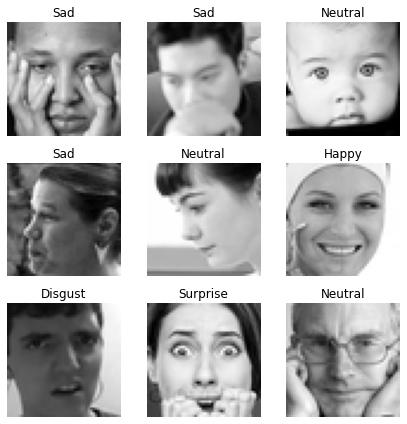

In [6]:
fig, axs = plt.subplots(3,3,figsize=(6,6))
axs = axs.flatten() 
for i in range(9):
    plt.subplot(axs[i])
    plt.gray()
    plt.imshow(X_train[i].reshape(48,48))
    plt.title(labels[Y_train[i].argmax()])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Part 2: Load dementia & normal data
Here we just use the dementia class in test dataset.

In [7]:
# all images we crawled from internet
path_dementia = '/content/drive/My Drive/STAT8021/project/dementia'
path_normal = '/content/drive/My Drive/STAT8021/project/normal'

In [8]:
image_size = (48,48) # use the same image size as facial expression data
batch_size1 = 553
batch_size2 = 528

dementia_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_dementia,
    # class_names=['dementia'],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size1,
)

normal_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_normal,
    # class_names=['normal'],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size1,
)

Found 553 files belonging to 1 classes.
Found 528 files belonging to 1 classes.


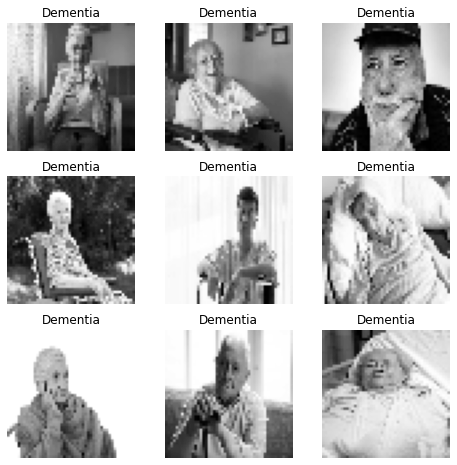

In [9]:
dementia_label = ['Dementia']

plt.figure(figsize=(8, 8))
for images, labels in dementia_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.image.rgb_to_grayscale(images[i]) # transfer the images from RGB to gray
        plt.imshow(img.numpy()[:,:,0],cmap ='gray')
        plt.title(dementia_label[int(labels[i])])
        plt.axis("off")

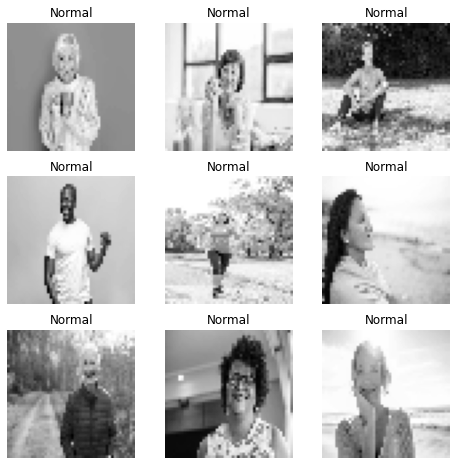

In [10]:
normal_label = ['Normal']

plt.figure(figsize=(8,8))
for images, labels in normal_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.image.rgb_to_grayscale(images[i]) # transfer the images from RGB to gray
        plt.imshow(img.numpy()[:,:,0],cmap ='gray')
        plt.title(normal_label[int(labels[i])])
        plt.axis("off")

In [11]:
'''
    change the data form tensor to ndarray,
    the same data type as facial expression data
'''
for images, labels in dementia_ds.take(1):
  img = tf.image.rgb_to_grayscale(images)
  dementia_x = img.numpy()
  dementia_y = labels.numpy().reshape(553,1)

for images, labels in normal_ds.take(1):
  img = tf.image.rgb_to_grayscale(images)
  normal_x = img.numpy()
  normal_y = labels.numpy().reshape(528,1)

## Part 3: Build CNN model for facial expression data

In [12]:
def call_existing_code(num_block,
                       num_units,
                       lr):

    inputs = layers.Input(shape=(48, 48, 1))

    x = layers.Conv2D(64, kernel_size=(3, 3),padding='same')(inputs)
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    for i in range(num_block):
        x = layers.Conv2D(128, kernel_size=(3, 3),padding='same')(x)
        x = layers.BatchNormalization()(x) 
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(256, kernel_size=(3, 3),padding='same')(x)
    x = layers.BatchNormalization()(x) 
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Flatten()(x)

    x = layers.Dense(num_units,activation='relu')(x)
    
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(7, activation="softmax")(x)
    
    model = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

def build_model(hp):
    num_block = hp.Int('num_block', min_value=1, max_value=3, step=1)
    num_units = hp.Int('num_units', min_value=32, max_value=256, step=32)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model = call_existing_code(
        num_block=num_block,
        num_units=num_units,
        lr=lr
    )
    return model

In [13]:
build_model(kt.HyperParameters())

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    seed=2022,
    overwrite=True
)


In [14]:
tuner.search(X_train, Y_train, epochs=3, 
             validation_data=(X_val, Y_val)) # find best parameters

Trial 5 Complete [00h 00m 23s]
val_accuracy: 0.4848484992980957

Best val_accuracy So Far: 0.4918147027492523
Total elapsed time: 00h 03m 00s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values) # show the best model parameters

{'num_block': 2, 'num_units': 64, 'lr': 0.00016468966822474475}


In [16]:
best_model = tuner.get_best_models(num_models=1)[0] # use the best parameter to build model
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856 

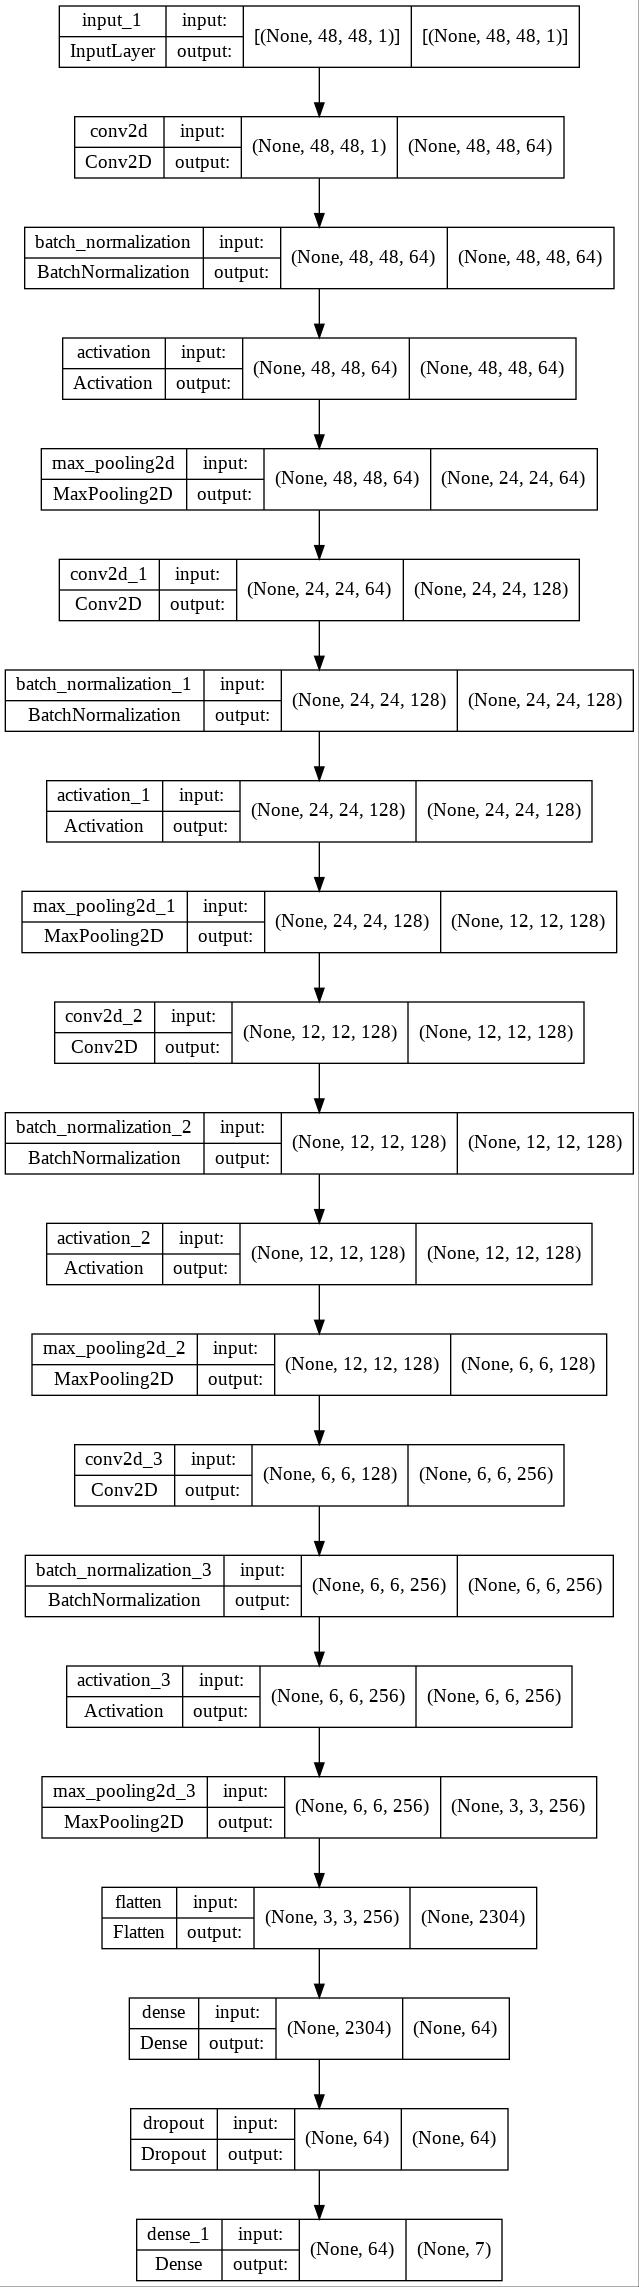

In [17]:
# plot the model
plot_model(best_model, to_file='/content/drive/My Drive/STAT8021/project/CNN_model.jpg', show_shapes=True)

In [18]:
model = build_model(best_hp)
# retrain the model over the training dataset
model.fit(x=X_train, y=Y_train, 
          epochs=30,
          batch_size =64,
          validation_data=(X_val,Y_val),
          shuffle=True)

Epoch 1/30
359/359 [==============================] - 7s 17ms/step - loss: 1.7114 - accuracy: 0.3146 - val_loss: 1.9188 - val_accuracy: 0.1923
Epoch 2/30
359/359 [==============================] - 6s 16ms/step - loss: 1.5070 - accuracy: 0.4117 - val_loss: 1.4480 - val_accuracy: 0.4566
Epoch 3/30
359/359 [==============================] - 6s 16ms/step - loss: 1.3812 - accuracy: 0.4630 - val_loss: 1.4131 - val_accuracy: 0.4580
Epoch 4/30
359/359 [==============================] - 6s 16ms/step - loss: 1.2914 - accuracy: 0.5005 - val_loss: 1.3742 - val_accuracy: 0.4861
Epoch 5/30
359/359 [==============================] - 6s 16ms/step - loss: 1.2016 - accuracy: 0.5426 - val_loss: 1.3198 - val_accuracy: 0.4998
Epoch 6/30
359/359 [==============================] - 6s 16ms/step - loss: 1.1311 - accuracy: 0.5688 - val_loss: 1.2647 - val_accuracy: 0.5176
Epoch 7/30
359/359 [==============================] - 6s 16ms/step - loss: 1.0563 - accuracy: 0.5976 - val_loss: 1.2982 - val_accuracy: 0.5152

## Part 4: Predictive facial expression for dementia

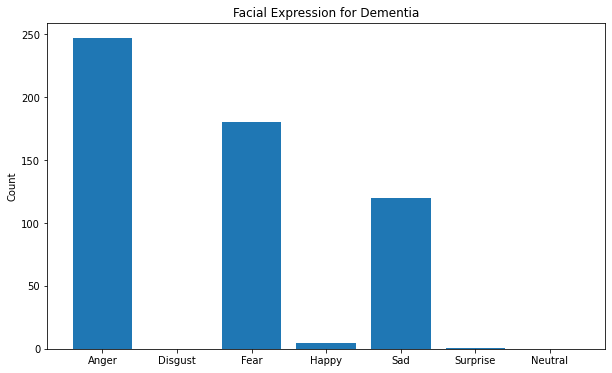

In [34]:
pre_facial_dementia = model.predict(dementia_x).argmax(axis=1)

labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
facial = []
freq = np.zeros(7)
for l in pre_facial_dementia:
    facial.append(labels[l])
    freq[l] += 1 # freq: array([247.,   0., 180., 5.,   120.,   1.,   0.])

fig = plt.figure(figsize=(10,6))
plt.bar(labels,freq)
plt.ylabel('Count')
plt.title('Facial Expression for Dementia')
plt.show()

## Part 5: Predictive facial expression for normal

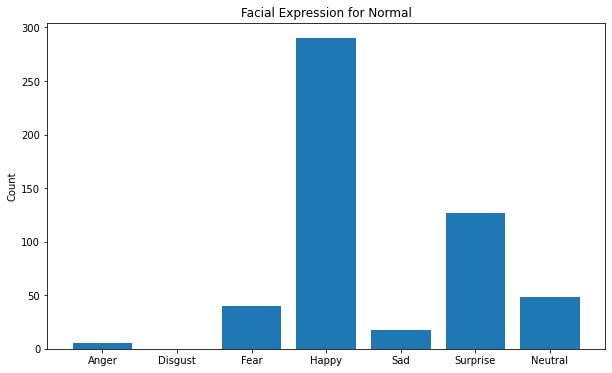

In [37]:
pre_facial_normal = model.predict(normal_x).argmax(axis=1)

labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
facial = []
freq = np.zeros(7)
for l in pre_facial_normal:
    facial.append(labels[l])
    freq[l] += 1 # freq: array([5.,   0., 40., 290.,   18.,   127.,   48.])

fig = plt.figure(figsize=(10,6))
plt.bar(labels,freq)
plt.ylabel('Count')
plt.title('Facial Expression for Normal')
plt.show()